## Implementing facial key point detection (regression problem)

Imagine a scenario where you are asked to predict the key points present on an image of a face, for example, the location of the eyes, nose and chin. In this scenario, we need to employ a new strategy to build a model to detect the key points.

Before we dive further, let's understand what we are trying to achieve here.Facial key points denote the markings of various key pionts on the image that contains a face.

To solve this problem, we would have to solve a few problems first.
* Images can be of different shapes:
    * This warrants an adjustment in the key point locations while adjusting images to bring them all to a standard image size.

* Facail key points are simmilar to points on a scatter plot, but scattered based on a certain pattern this time.
  * This means the values are anywhere between 0 and 224 if the image is resized to a shape of 224x224x3.

* Normalize the dependent variable (the location of facial key points) as per size of the image:
  * The key point values are always between 0 and 1 if we consider their location relative to image dimensions.

* Given that the dependent variable values are always between 0 and 1, we can use a sigmoid layer at the end to fetch values that will be between 0 and 1.

Let's formulate the pipeline of solving this use case:
1. Import the relevant packages

2. Import the data.

3. Define the class that prepares the dataset:
  * Ensure appropriate pre-processing is done on the input images to perform transfer learning.

  * Ensure that the location of key points is processed in such away that we fetch their relative position with respect to the processed image.

4. Define the model, loss function, and optimizer:
  * The loss fucntion is mean absolute error, as the output is a continous value between 0 and 1.


5. Train the model over increasing epochs.



In [1]:
# 1. Import the relevant packages and the dataset
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import numpy as np, pandas as pd, os, glob, cv2
#from mpl_toolkits.mplots3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
from sklearn import cluster
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
!pip install torchinfo


In [3]:
from torchinfo import summary

In [4]:
# 2. Download and import the relevant data


In [5]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6049 (delta 3), reused 7 (delta 2), pack-reused 6038 (from 1)
Receiving objects: 100% (6049/6049), 329.53 MiB | 17.19 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (5805/5805), done.


In [6]:
data

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3457,Thomas_Ferguson_02.jpg,35.0,94.0,35.0,105.0,38.0,112.0,40.0,123.0,46.0,...,71.0,123.0,79.0,121.0,71.0,123.0,66.0,126.0,64.0,126.0
3458,Valerie_Harper_00.jpg,72.0,133.0,76.0,147.0,80.0,159.0,87.0,170.0,91.0,...,120.0,156.0,135.0,159.0,124.0,163.0,117.0,167.0,113.0,166.0
3459,Maggie_Smith_00.jpg,52.0,149.0,56.0,160.0,63.0,168.0,71.0,179.0,78.0,...,122.0,169.0,133.0,169.0,122.0,172.0,115.0,172.0,111.0,172.0
3460,Erin_Hershey_Presley_41.jpg,82.0,91.0,82.0,105.0,82.0,116.0,86.0,128.0,90.0,...,119.0,132.0,134.0,136.0,119.0,139.0,112.0,139.0,108.0,139.0


In [7]:
# 3. Define the FacesData class that provides input and output data points
# for the data loader
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2, numpy as np
from copy import deepcopy

class FacesData(Dataset):
  def __init__(self, df):
    super(FacesData).__init__()
    self.df = df
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.255])

  def __len__(self): return len(self.df)

  def __getitem__(self, ix):
    img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix, 0]
    img = cv2.imread(img_path)/255.
    kp = deepcopy(self.df.iloc[ix, 1:].tolist())
    kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
    kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
    kp2 = kp_x + kp_y
    kp2 = torch.tensor(kp2)
    img = self.preprocess_input(img)
    return img, kp2

  def preprocess_input(self, img):
    img = cv2.resize(img, (224, 224))
    img = torch.tensor(img).permute(2, 0, 1)
    img = self.normalize(img).float()
    return img.to(device)

  def load_img(self, ix):
    img_path = 'P1_Facial_Keypoints/data'
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
    img = cv2.resize(img, (224, 224))
    return  img

In [8]:
import os
Num_workers = os.cpu_count()
import torch
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)


In [9]:
# 4. Let's now create a training and test data split and establish training and
# test datasets and data loaders

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=101)

train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=Num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=Num_workers, pin_memory=True)

In [10]:
# 5. Define the model that we will leverage to identify key points in an image
def get_model():
  # 1. Load the pre-trained VGG16 model
  weights = models.VGG16_Weights.DEFAULT
  model = models.vgg16(weights=weights)

  # 2.freeze the parameters
  for param in model.parameters():
    param.requires_grad = False

  # 3.Overwrite and unfreeze the parameters of the last two layers of the model
  model.avgpool = nn.Sequential(
    nn.Conv2d(512, 512, 3),
    nn.MaxPool2d(2),
    nn.Flatten()
  )

  model.classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 136),
    nn.Sigmoid()
  )

  # 4. Define the loss function and optimizer
  loss_fn = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

  return model.to(device), loss_fn, optimizer

In [11]:
model, loss_fn, optimizer = get_model()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 98.7MB/s]


In [12]:
# 7. Define the functions to train on batch of data points and also to validate
# on the test dataset
def train_batch(img, kps, model, optimizer, loss_fn):
  model.train()
  _kps = model(img.to(device))
  loss = loss_fn(_kps, kps.to(device))
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss


# function that returns loss on the test data and the predicted keypoints
@torch.no_grad()
def validate_batch(img, kps, model, loss_fn):
  model.eval()
  _kps = model(img.to(device))
  loss = loss_fn(_kps, kps.to(device))
  return _kps, loss


In [14]:
# 8. Train the model based on training the data loader and test it on the test data
train_loss, test_loss = [], []
n_epochs = 50

for epoch in range(n_epochs):
  print(f"epoch {epoch +1}:50")
  epoch_train_loss, epoch_test_loss = 0, 0
  for ix, (img, kps) in enumerate(train_loader):
    loss = train_batch(img, kps, model, optimizer, loss_fn)
    epoch_train_loss += loss.item()

  epoch_train_loss /= (ix+1)

  for ix, (img, kps) in enumerate(test_loader):
    ps, loss = validate_batch(img, kps, model, loss_fn)
    epoch_test_loss += loss.item()

  epoch_test_loss /= (ix+1)

  train_loss.append(epoch_train_loss)
  test_loss.append(epoch_test_loss)


epoch 1:50


KeyboardInterrupt: 

## 2d and 3d facial key point detection

In this section, we'll leverage a pre-trained model that can detect the 2d and 3d key points present in a face in a few lines of code.


In [15]:
# 1. Install the required packages
!pip install -qU face-alignment
import face_alignment, cv2

In [16]:
# 2.Import the image
!wget https://www.dropbox.com/s/2s7xjto7rb6q7dc/Hema.JPG

--2024-09-21 08:56:25--  https://www.dropbox.com/s/2s7xjto7rb6q7dc/Hema.JPG
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/q9tl4zcyl1ozciwgkm5zh/Hema.JPG?rlkey=hz1t466k39bhdd9p6h1jq6gny [following]
--2024-09-21 08:56:26--  https://www.dropbox.com/scl/fi/q9tl4zcyl1ozciwgkm5zh/Hema.JPG?rlkey=hz1t466k39bhdd9p6h1jq6gny
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucab1f869c6afd61e1cbfea22222.dl.dropboxusercontent.com/cd/0/inline/Ca_s9MJcmMUEKsayyhDlgGP_HimZKZvjAPTseBJiunU_dN7NeW3GSRknYVNZgja2pvZ5p75LymlyqlzVYryHW_rTRzEVVU4K0alnhzkBtwppluKbjEcGAKcb2Vm9tS02_fVu2SjLzT1TniBsA8UNEZqM/file# [following]
--2024-09-21 08:56:27--  https://ucab1f869c6afd61e1cbfea22222.dl.dropboxusercontent.com/cd/0/inline/Ca_s9MJcmM

In [17]:
# Define the face alignment method, where we specify whether we want to fetch
# key point landmarks in 2D or 3D

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D,
                                  flip_input=False,
                                  device='cpu')

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth
100%|██████████| 85.7M/85.7M [00:05<00:00, 16.9MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip
100%|██████████| 91.9M/91.9M [00:06<00:00, 15.7MB/s]


In [18]:
# 4. Read the input image and provide it to the get_landmarks method
input = cv2.imread('Hema.JPG')
preds = fa.get_landmarks(input)[0]
print(preds.shape)

(68, 2)


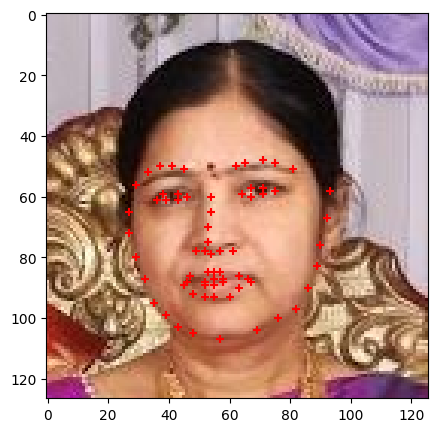

In [19]:
# 5. Plot the image with the detected key points
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(cv2.cvtColor(cv2.imread('Hema.JPG'), cv2.COLOR_BGR2RGB))
ax.scatter(preds[:,0], preds[:,1], marker="+", c="r")
plt.show()

In [20]:
# In a similar manner, the 3D projections of facial key points are obtained as follows
fa = face_alignment.FaceAlignment(
  face_alignment.LandmarksType.THREE_D,
  flip_input=False, device="cpu"
)
input = cv2.imread('Hema.JPG')
preds = fa.get_landmarks(input)[0]
import pandas as pd
df = pd.DataFrame(preds)
df.columns = ['x', 'y', 'z']
import plotly.express as px
fig = px.scatter_3d(df, x='x', y='y', z='z')
fig.show()

Downloading: "https://www.adrianbulat.com/downloads/python-fan/3DFAN4-4a694010b9.zip" to /root/.cache/torch/hub/checkpoints/3DFAN4-4a694010b9.zip
100%|██████████| 91.9M/91.9M [00:05<00:00, 16.6MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/depth-6c4283c0e0.zip" to /root/.cache/torch/hub/checkpoints/depth-6c4283c0e0.zip
100%|██████████| 224M/224M [00:12<00:00, 18.6MB/s]
